In [7]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Let's start by building 5000 scenarios for interest rates, a duration matched bond portfolio (proxied by a zero coupon bond) and a stock portfolio.
n_scenarios =  5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0 = 0.03, sigma=0.02)
price_eq = erk.gbm(n_years=10,n_scenarios=n_scenarios, mu=0.07, sigma=0.15)


In [9]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75)],
          axis=1).round(2)

,ZC,Eq,70/30
mean,1.34,1.99,1.77
std,0.00,0.99,0.60
p_breach,NaN,0.03,0.01
e_short,NaN,0.12,0.08
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


The above results are not taking the floor value into consideration. We will create a new allocator function that includes the floor value -- floor allocator function in the erk module.

In [10]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75,  zc_prices=zc_prices[1:])
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75
mean,1.34,1.99,1.77,1.97
std,0.00,0.99,0.60,1.00
p_breach,NaN,0.03,0.01,NaN
e_short,NaN,0.12,0.08,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


As we see above, there are negligible breaches by the Floor75 allocation, even though it has a similar mean return and same std dev as the equity allocation

In [11]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=1)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1
mean,1.34,1.99,1.77,1.97,1.63
std,0.00,0.99,0.60,1.00,0.44
p_breach,NaN,0.03,0.01,NaN,NaN
e_short,NaN,0.12,0.08,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN


In [12]:
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=5)
rets_floor75m10 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=10)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75)
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m10
mean,1.34,1.99,1.77,1.97,1.63,1.98,1.98
std,0.00,0.99,0.60,1.00,0.44,1.00,1.00
p_breach,NaN,0.03,0.01,NaN,NaN,0.00,0.03
e_short,NaN,0.12,0.08,NaN,NaN,0.00,0.00
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


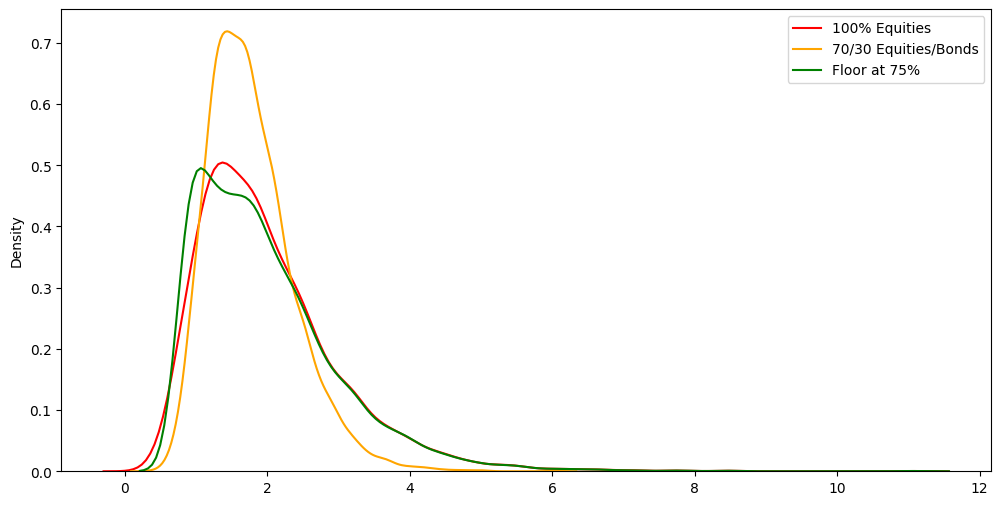

In [14]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_floor75m1 = erk.terminal_values(rets_floor75m1)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.kdeplot(tv_eq, color="red", label="100% Equities")
#sns.kdeplot(tv_zc, color="blue", label="100% Immunized Bonds")
sns.kdeplot(tv_7030b, color="orange", label="70/30 Equities/Bonds")
sns.kdeplot(tv_floor75, color="green", label="Floor at 75%")

plt.legend();

# Risk Budgeting with Drawdown Constraints

In [16]:
# drawdown allocator function added to erk module
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75),
           erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)           
          ],
          axis=1).round(4)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m10,MaxDD25
mean,1.3433,1.9941,1.7723,1.9690,1.6326,1.9801,1.9834,1.6432
std,0.0000,0.9883,0.5993,0.9953,0.4361,0.9967,0.9966,0.5454
p_breach,NaN,0.0334,0.0070,NaN,NaN,0.0002,0.0252,NaN
e_short,NaN,0.1177,0.0844,NaN,NaN,0.0021,0.0048,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].head()

0   -0.144746
1   -0.133413
2   -0.180277
3   -0.114119
4   -0.114539
Name: Max Drawdown, dtype: float64

In [18]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.234322391217735

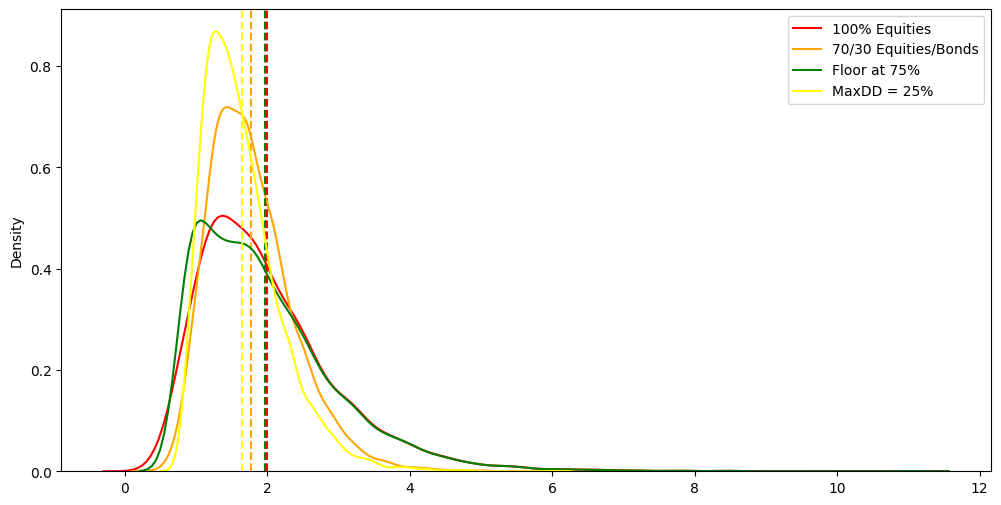

In [19]:
# Plot
plt.figure(figsize=(12, 6))
sns.kdeplot(tv_eq, color="red", label="100% Equities")
plt.axvline(tv_eq.mean(), ls="--", color="red")
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
#plt.axvline(tv_zc.mean(), ls="--", color="blue")
sns.kdeplot(tv_7030b, color="orange", label="70/30 Equities/Bonds")
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.kdeplot(tv_floor75, color="green", label="Floor at 75%")
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.kdeplot(tv_maxdd25, color="yellow", label="MaxDD = 25%")
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend();

# Drawdown Constraints with Historical Data

c:\Users\shantala.mukherjee\OneDrive - Invartis Consulting\Python\edhec_risk_kit.py:71: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("ind30_m_nfirms.csv",
c:\Users\shantala.mukherjee\OneDrive - Invartis Consulting\Python\edhec_risk_kit.py:59: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("ind30_m_size.csv",
c:\Users\shantala.mukherjee\OneDrive - Invartis Consulting\Python\edhec_risk_kit.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("ind30_m_rets.csv",


<Axes: >

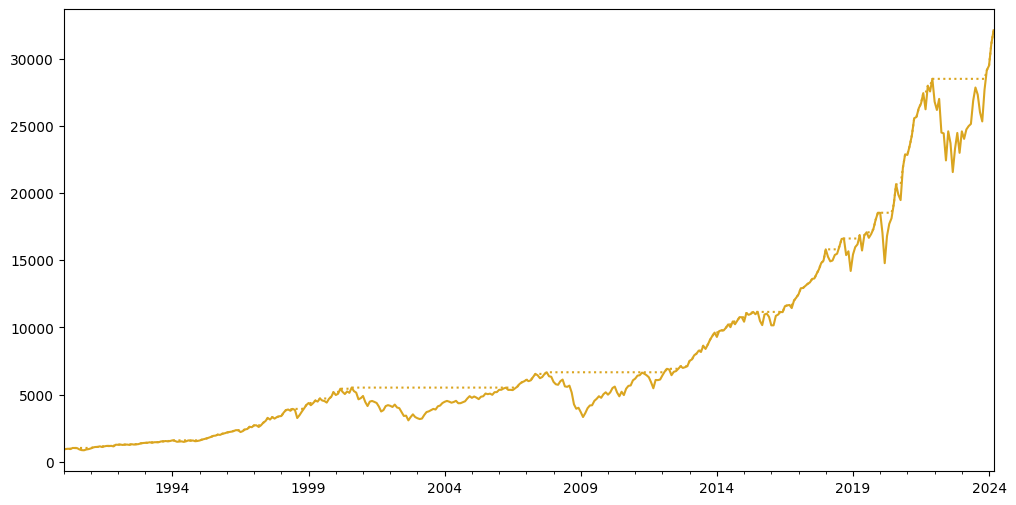

In [22]:
rets_tmi =  erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")

<Axes: >

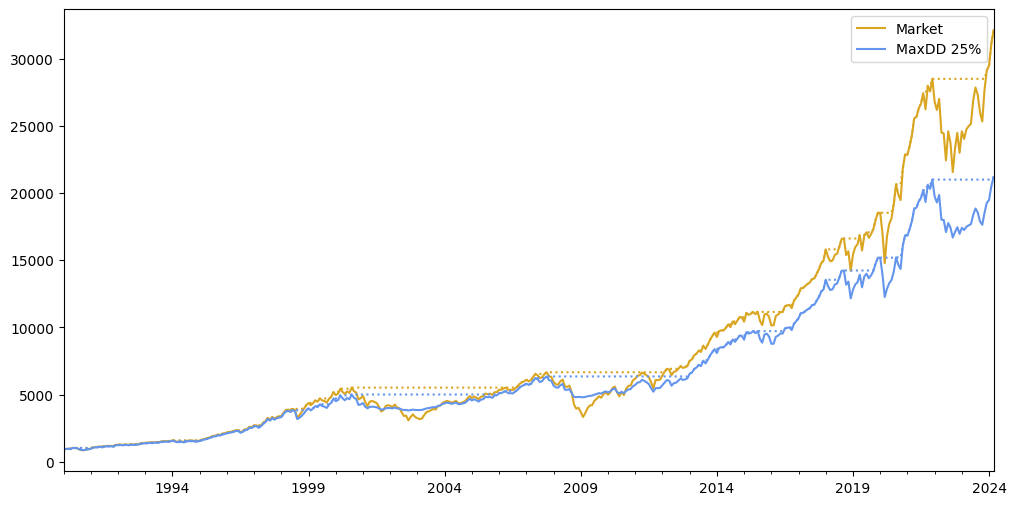

In [23]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Previous Peak"].plot(ax=ax, color="cornflowerblue", ls=":")

In [24]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.106612,0.152562,-0.562308,4.021747,0.068760,0.096999,0.488583,-0.500280
MaxDD,0.093242,0.118650,-0.624827,4.897716,0.052738,0.076320,0.518643,-0.244282
